<a href="https://colab.research.google.com/github/JeremiahObikoya/Plant-disease-model-CPE/blob/main/Plant_Diseases_Detection_with_TF2_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TensorFlow Lite End-to-End Android Application

By [Yannick Serge Obam](https://www.linkedin.com/in/yannick-serge-obam/)

For this project,  we will create an end-to-end Android application with TFLite that will then be open-sourced as a template design pattern.

 We opte to develop an **Android application that detects plant diseases**.

<img src='https://github.com/obeshor/Plant-Diseases-Detector/blob/master/assets/detect_crop_disease_in_africa.jpg?raw=1' width=-500px>

The project is broken down into multiple steps:

* Building and creating a machine learning model using TensorFlow with Keras
* Deploying the model to an Android application using TFLite
* Documenting and open-sourcing the development process






##**Machine Learning  model using Tensorflow with Keras**

We designed algorithms and models to recognize species and diseases in the crop leaves by using Convolutional Neural Network


### **Importing  the Librairies**

In [2]:
# Install nightly package for some functionalities that aren't in alpha
# !pip install tf-nightly-gpu-2.0-preview

# Install TF Hub for TF2
# !pip install 'tensorflow-hub == 0.15.0'
# !pip install tensorflow==2.13.0
!pip install numpy==1.24.4
# !pip install --upgrade ml_dtypes jax jaxlib
# !pip uninstall -y jax jaxlib ml_dtypes

  Using cached numpy-1.24.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.6 kB)
Using cached numpy-1.24.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.4
    Uninstalling numpy-2.2.4:
      Successfully uninstalled numpy-2.2.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.1.2 requires jax>=0.1.72, which is not installed.
dopamine-rl 4.1.2 requires jaxlib>=0.1.51, which is not installed.
tensorstore 0.1.72 requires ml_dtypes>=0.3.1, which is not installed.
optax 0.2.4 requires jax>=0.4.27, which is not installed.
optax 0.2.4 requires jaxlib>=0.4.27, which is not installed.
chex 0.1.89 requires jax>=0.4.27, which is not installed.
chex 0.1.89 requires jaxlib>=0.4.27, which is not installed.
orbax-checkpoint 0.11.8 requires jax>=

In [1]:
import sys
sys.setrecursionlimit(10000)
import tensorflow as tf

from __future__ import absolute_import, division, print_function, unicode_literals


# import tensorflow as tf
#tf.logging.set_verbosity(tf.logging.ERROR)
#tf.enable_eager_execution()

import tensorflow_hub as hub
import os
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
#from keras import optimizers




In [2]:
# verify TensorFlow version

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Version:  2.13.0
Eager mode:  True
Hub version:  0.15.0
GPU is NOT AVAILABLE


### Load the data
We will download a public dataset of 54,305 images of diseased and healthy plant leaves collected under controlled conditions ( [PlantVillage Dataset](https://storage.googleapis.com/plantdata/PlantVillage.tar)). The images cover 14 species of crops, including: apple, blueberry, cherry, grape, orange, peach, pepper, potato, raspberry, soy, squash, strawberry and tomato. It contains images of 17 basic diseases, 4 bacterial diseases, 2 diseases caused by mold (oomycete), 2 viral diseases and 1 disease caused by a mite. 12 crop species also have healthy leaf images that are not visibly affected by disease. Then store the downloaded zip file to the "/tmp/" directory.

we'll  need to make sure the input data is resized to 224x224 or 229x229 pixels as required by the networks.



In [3]:
"""
zip_file = tf.keras.utils.get_file(origin='https://data.mendeley.com/public-files/datasets/tywbtsjrjv/1',
                                          fname='Plant_leaf_diseases_dataset_with_augmentation.zip', extract=True)
"""
import requests
import zipfile
import io

url = 'https://data.mendeley.com/public-files/datasets/tywbtsjrjv/files/d5652a28-c1d8-4b76-97f3-72fb80f94efc/file_downloaded'
headers = {'User-Agent': 'Mozilla/5.0'}

response = requests.get(url, headers=headers)
if response.status_code == 200:
    # Extract the zip file from memory
    z = zipfile.ZipFile(io.BytesIO(response.content))
    z.extractall()  # Extracts all files into the current directory
else:
    print("Failed to download file. HTTP status code:", response.status_code)


### Prepare training and validation  dataset
Create the training and validation directories

In [3]:
# Assuming the folder 'PlantVillage' is created upon extraction
extracted_folder = os.path.join(os.getcwd(), 'PlantVillage')
data_dir = extracted_folder
train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'validation')


In [5]:
import os
import shutil
import random


base_dir = "PlantVillage"  # or the path to your PlantVillage folder

train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "validation")

# Create train/validation directories if they don’t exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)



# For reproducible splits, set a seed
random.seed(42)

# Loop over each subfolder in PlantVillage (each class)
for class_folder in os.listdir(base_dir):
    class_path = os.path.join(base_dir, class_folder)

    # Skip any non-directory (files) or the newly created train/validation folders
    if not os.path.isdir(class_path):
        continue
    if class_folder in ["train", "validation"]:
        continue

    # Gather all images in this class folder
    images = [
        os.path.join(class_path, f)
        for f in os.listdir(class_path)
        if f.lower().endswith((".jpg", ".jpeg", ".png"))
    ]

    # Shuffle images to ensure random split
    random.shuffle(images)

    # Calculate split index (80% train, 20% validation)
    split_idx = int(0.8 * len(images))
    train_images = images[:split_idx]
    val_images = images[split_idx:]

    # Create matching class subfolders in train/validation
    train_class_dir = os.path.join(train_dir, class_folder)
    val_class_dir = os.path.join(val_dir, class_folder)
    os.makedirs(train_class_dir, exist_ok=True)
    os.makedirs(val_class_dir, exist_ok=True)

    # Move images into train or validation subfolders
    for img_path in train_images:
        shutil.move(img_path, train_class_dir)
    for img_path in val_images:
        shutil.move(img_path, val_class_dir)

    print(f"{class_folder}: {len(train_images)} train, {len(val_images)} validation")


Apple___Black_rot: 496 train, 125 validation
Cherry___Powdery_mildew: 841 train, 211 validation
Tomato___healthy: 1272 train, 319 validation
Grape___Leaf_blight_(Isariopsis_Leaf_Spot): 860 train, 216 validation
Apple___healthy: 1316 train, 329 validation
Background_without_leaves: 914 train, 229 validation
Grape___healthy: 338 train, 85 validation
Raspberry___healthy: 296 train, 75 validation
Blueberry___healthy: 1201 train, 301 validation
Tomato___Spider_mites Two-spotted_spider_mite: 1340 train, 336 validation
Pepper,_bell___healthy: 1182 train, 296 validation
Tomato___Bacterial_spot: 1701 train, 426 validation
Strawberry___Leaf_scorch: 887 train, 222 validation
Corn___Northern_Leaf_Blight: 788 train, 197 validation
Grape___Black_rot: 944 train, 236 validation
Tomato___Late_blight: 1527 train, 382 validation
Grape___Esca_(Black_Measles): 1106 train, 277 validation
Potato___Late_blight: 800 train, 200 validation
Orange___Haunglongbing_(Citrus_greening): 4405 train, 1102 validation
Squ

In [4]:
def count_files_in_dir(dir_path):
    total = 0
    for root, dirs, files in os.walk(dir_path):
        total += len([f for f in files if f.lower().endswith((".jpg", ".jpeg", ".png"))])
    return total

print("Train images:", count_files_in_dir(train_dir))
print("Validation images:", count_files_in_dir(validation_dir))


Train images: 44343
Validation images: 11105


### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `categories.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the plants and diseases.

In [7]:
!!wget https://github.com/obeshor/Plant-Diseases-Detector/archive/master.zip
!unzip master.zip;

Archive:  master.zip
33dc8985c943175a7a1301fe034c01d69bebb8cf
   creating: Plant-Diseases-Detector-master/
   creating: Plant-Diseases-Detector-master/GreenDoctor/
  inflating: Plant-Diseases-Detector-master/GreenDoctor/.gitignore  
   creating: Plant-Diseases-Detector-master/GreenDoctor/.idea/
   creating: Plant-Diseases-Detector-master/GreenDoctor/.idea/codeStyles/
  inflating: Plant-Diseases-Detector-master/GreenDoctor/.idea/codeStyles/Project.xml  
  inflating: Plant-Diseases-Detector-master/GreenDoctor/.idea/codeStyles/codeStyleConfig.xml  
  inflating: Plant-Diseases-Detector-master/GreenDoctor/.idea/encodings.xml  
  inflating: Plant-Diseases-Detector-master/GreenDoctor/.idea/jarRepositories.xml  
  inflating: Plant-Diseases-Detector-master/GreenDoctor/.idea/misc.xml  
  inflating: Plant-Diseases-Detector-master/GreenDoctor/.idea/runConfigurations.xml  
  inflating: Plant-Diseases-Detector-master/GreenDoctor/.idea/vcs.xml  
   creating: Plant-Diseases-Detector-master/GreenDoctor

In [5]:
import json

with open('Plant-Diseases-Detector-master/categories.json', 'r') as f:
    cat_to_name = json.load(f)
    classes = list(cat_to_name.values())

print (classes)

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Sp

In [6]:
print('Number of classes:',len(classes))

Number of classes: 38


###Select the Hub/TF2 module to use

In [7]:
module_selection = ("mobilenet_v2", 224, 1280) #@param ["(\"mobilenet_v2\", 224, 1280)", "(\"inception_v3\", 299, 2048)"] {type:"raw", allow-input: true}
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/imagenet/{}_140_224/feature_vector/5".format(handle_base)
# https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/5
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(
  MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

BATCH_SIZE = 64 #@param {type:"integer"}

Using https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/5 with input size (224, 224) and output dimension 1280


### Data Preprocessing

Let's set up data generators that will read pictures in our source folders, convert them to `float32` tensors, and feed them (with their labels) to our network.

As you may already know, data that goes into neural networks should usually be normalized in some way to make it more amenable to processing by the network. (It is uncommon to feed raw pixels into a convnet.) In our case, we will preprocess our images by normalizing the pixel values to be in the `[0, 1]` range (originally all values are in the `[0, 255]` range).



In [8]:
# Inputs are suitably resized for the selected module. Dataset augmentation (i.e., random distortions of an image each time it is read) improves training, esp. when fine-tuning.

validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    shuffle=False,
    seed=42,
    color_mode="rgb",
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

do_data_augmentation = True #@param {type:"boolean"}
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255,
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      fill_mode='nearest' )
else:
  train_datagen = validation_datagen

train_generator = train_datagen.flow_from_directory(
    train_dir,
    subset="training",
    shuffle=True,
    seed=42,
    color_mode="rgb",
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)


Found 11105 images belonging to 39 classes.
Found 44343 images belonging to 39 classes.


###Build the model
All it takes is to put a linear classifier on top of the feature_extractor_layer with the Hub module.

For speed, we start out with a non-trainable feature_extractor_layer, but you can also enable fine-tuning for greater accuracy.

In [9]:
feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE+(3,),
                                   output_shape=[FV_SIZE])




In [10]:
do_fine_tuning = False #@param {type:"boolean"}
if do_fine_tuning:
  feature_extractor.trainable = True
  # unfreeze some layers of base network for fine-tuning
  for layer in base_model.layers[-30:]:
    layer.trainable =True

else:
  feature_extractor.trainable = False


In [11]:
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax',
                           kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
#model.build((None,)+IMAGE_SIZE+(3,))

model.summary()

Building model with https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/5
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1792)              4363712   
                                                                 
 flatten (Flatten)           (None, 1792)              0         
                                                                 
 dense (Dense)               (None, 512)               918016    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 39)                20007     
                                                                 
Total params: 5301735 (20.22 MB)
Trainable params: 938023 (3.58 MB)
Non-trainable params: 436371

### Specify Loss Function and Optimizer

In [12]:
#Compile model specifying the optimizer learning rate

LEARNING_RATE = 0.001 #@param {type:"number"}

model.compile(
   optimizer=tf.keras.optimizers.Adam(lr=LEARNING_RATE),
   loss='categorical_crossentropy',
   metrics=['accuracy'])



### Train Model
train model using validation dataset for validate each steps

In [13]:

EPOCHS=5 #@param {type:"integer"}

history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples//train_generator.batch_size,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples//validation_generator.batch_size)

<ipython-input-13-2ce5b674b8b4>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/5
692/692 [==============================] - 4143s 6s/step - loss: 0.4683 - accuracy: 0.8615 - val_loss: 0.2093 - val_accuracy: 0.9369
Epoch 2/5
692/692 [==============================] - 4176s 6s/step - loss: 0.2241 - accuracy: 0.9275 - val_loss: 0.1994 - val_accuracy: 0.9347
Epoch 3/5
692/692 [==============================] - 4109s 6s/step - loss: 0.1909 - accuracy: 0.9383 - val_loss: 0.1771 - val_accuracy: 0.9431
Epoch 4/5
692/692 [==============================] - 4105s 6s/step - loss: 0.1754 - accuracy: 0.9448 - val_loss: 0.1421 - val_accuracy: 0.9529
Epoch 5/5
692/692 [==============================] - 4086s 6s/step - loss: 0.1629 - accuracy: 0.9473 - val_loss: 0.1641 - val_accuracy: 0.9474


###Check Performance
Plot training and validation accuracy and loss

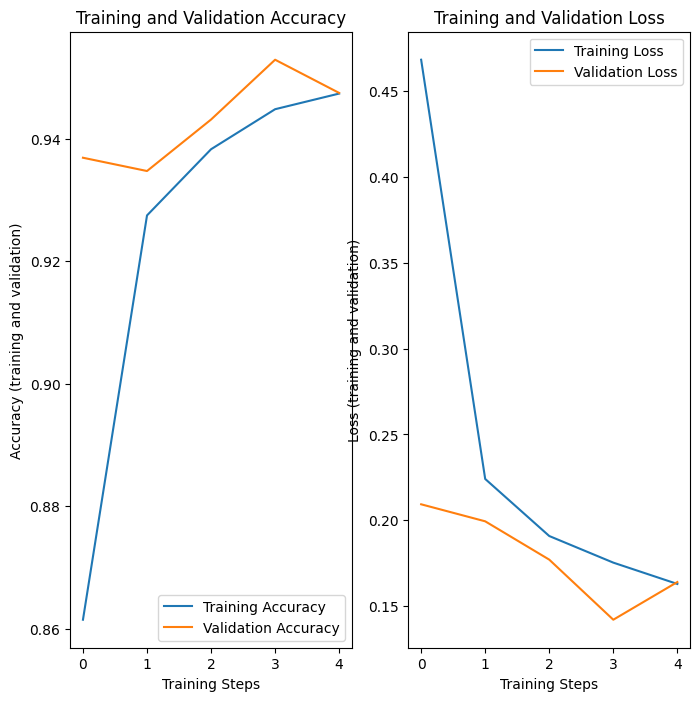

In [14]:
import matplotlib.pylab as plt
import numpy as np

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.show()

### Random test
Random sample images from validation dataset and predict

In [15]:
# Import OpenCV
import cv2

# Utility
import itertools
import random
from collections import Counter
from glob import iglob


def load_image(filename):
    img = cv2.imread(os.path.join(data_dir, validation_dir, filename))
    img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1]) )
    img = img /255

    return img


def predict(image):
    probabilities = model.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)

    return {classes[class_idx]: probabilities[class_idx]}

SOURCE: class: Orange___Haunglongbing_(Citrus_greening), file: Orange___Haunglongbing_(Citrus_greening)/image (3557).JPG
1/1 [==============================] - 1s 938ms/step
PREDICTED: class: Peach___Bacterial_spot, confidence: 0.984832


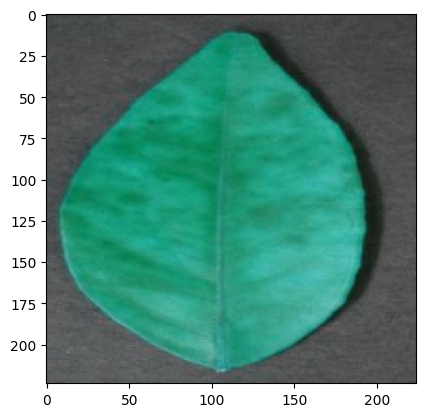

<Figure size 640x480 with 0 Axes>

SOURCE: class: Orange___Haunglongbing_(Citrus_greening), file: Orange___Haunglongbing_(Citrus_greening)/image (4561).JPG
1/1 [==============================] - 0s 66ms/step
PREDICTED: class: Peach___Bacterial_spot, confidence: 0.999958


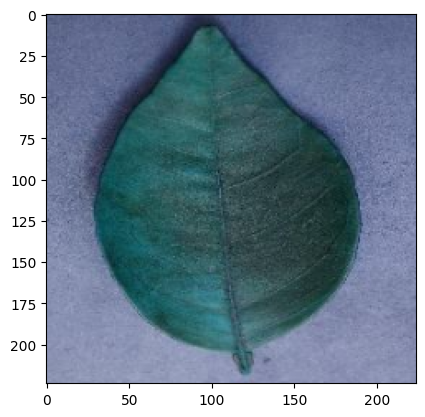

SOURCE: class: Orange___Haunglongbing_(Citrus_greening), file: Orange___Haunglongbing_(Citrus_greening)/image (1203).JPG
1/1 [==============================] - 0s 80ms/step
PREDICTED: class: Peach___Bacterial_spot, confidence: 0.999967


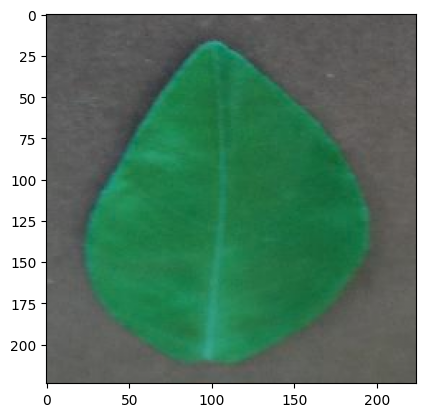

<Figure size 640x480 with 0 Axes>

SOURCE: class: Tomato___Tomato_Yellow_Leaf_Curl_Virus, file: Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (5184).JPG
1/1 [==============================] - 0s 62ms/step
PREDICTED: class: Tomato___Late_blight, confidence: 0.910637


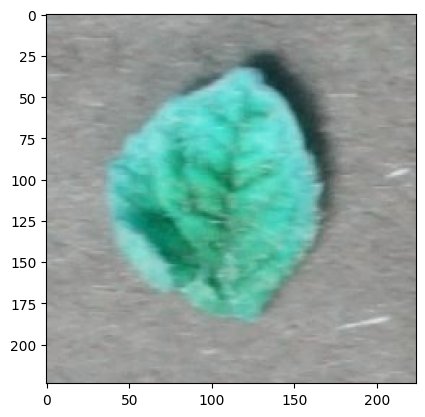

<Figure size 640x480 with 0 Axes>

SOURCE: class: Soybean___healthy, file: Soybean___healthy/image (4996).JPG
1/1 [==============================] - 0s 69ms/step
PREDICTED: class: Squash___Powdery_mildew, confidence: 0.999990


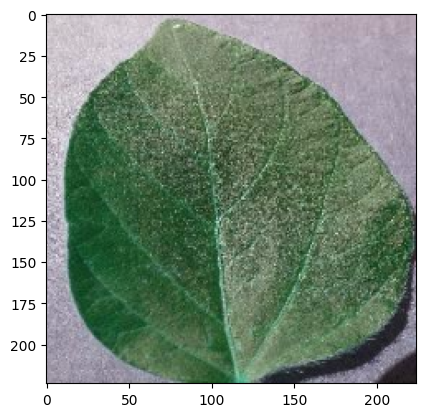

<Figure size 640x480 with 0 Axes>

In [16]:
for idx, filename in enumerate(random.sample(validation_generator.filenames, 5)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))

    img = load_image(filename)
    prediction = predict(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)
    plt.show()

## Export as saved model and convert   to TFLite
Now that you've trained the model, export it as a saved model

In [25]:
import time
t = time.time()

# export_path = "/tmp/saved_models/{}".format(int(t))
# tf.keras.experimental.export_saved_model(model, export_path)

# For older versions only
export_path = f"/tmp/saved_models/{int(time.time())}"
# tf.saved_models.save(model, export_path)
model.save(export_path, save_format="tf")
export_path

'/tmp/saved_models/1742484535'

In [26]:
# Now confirm that we can reload it, and it still gives the same results
reloaded = tf.keras.models.load_model(export_path, custom_objects={'KerasLayer':hub.KerasLayer})

In [27]:
def predict_reload(image):
    probabilities = reloaded.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)

    return {classes[class_idx]: probabilities[class_idx]}

SOURCE: class: Pepper,_bell___healthy, file: Pepper,_bell___healthy/image (859).JPG
1/1 [==============================] - 1s 1s/step
PREDICTED: class: Potato___Early_blight, confidence: 0.999972


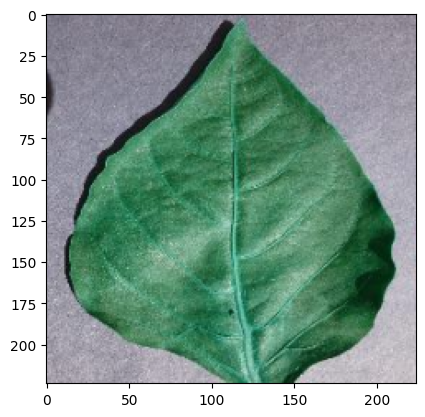

<Figure size 640x480 with 0 Axes>

SOURCE: class: Tomato___Bacterial_spot, file: Tomato___Bacterial_spot/image (1847).JPG
1/1 [==============================] - 0s 140ms/step
PREDICTED: class: Tomato___Early_blight, confidence: 0.729921


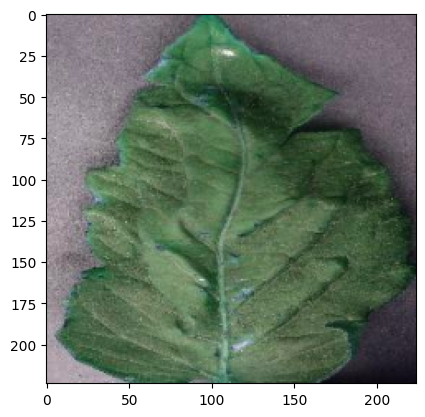

In [28]:
for idx, filename in enumerate(random.sample(validation_generator.filenames, 2)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))

    img = load_image(filename)
    prediction = predict_reload(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)
    plt.show()

In [29]:
# convert the model to TFLite
!mkdir "tflite_models"
TFLITE_MODEL = "tflite_models/plant_disease_model.tflite"


# Get the concrete function from the Keras model.
run_model = tf.function(lambda x : reloaded(x))

# Save the concrete function.
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype)
)

# Convert the model to standard TensorFlow Lite model
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converted_tflite_model = converter.convert()
open(TFLITE_MODEL, "wb").write(converted_tflite_model)

21007380

## CONCLUSION
The model can be improved if you change some hyperparameters. You can try using a different pretrained model. It's up to you. Let me know if you can improve the accuracy! Let's develop an Android app that uses this model.